# System Ranking

In [1]:
# Function: system effectiveness and ranking via trectools (MAP, NDCG@k)
from typing import Tuple, Optional, Union
from pathlib import Path
import os, glob
import pandas as pd
from helpers import *



### Ranking Compatibility Scores MAP NDGC@10

In [2]:
pd.set_option('display.float_format', lambda x: f"{x:.5f}")
datasets = ['dl-2019', 'dl-2020']
scenarios = ['summarisation_80tokens', 'summarisation_120tokens', 'fulldocs']
models = ['gpt-4o', 'llama3.18b']


from itertools import product
import pickle
agreement_rows = []
human_scores = {}
llm_scores = {}
for dataset_name, scenario_name, model_name in product(datasets, scenarios, models):
    if not human_scores.get(dataset_name):
        print (f"Processing human ranking scores for dataset: {dataset_name}")
        human_qrels = f"../data/msmarco-passage-trec-{dataset_name}-judged/qrels/trec.qrels.txt"
        df_human, df_human_ranking_map, df_human_ranking_ndcg = compute_system_ranking(
            qrels=human_qrels,
            runs_dir=f"../data/runs/trec-{dataset_name}",
            ndcg_cutoff=10,
            dataset_name=dataset_name,
            scenario_name="human",
        )
        human_scores[dataset_name] = {
            "scores": df_human.set_index('system'),
            "ranking_map": df_human_ranking_map,
            "ranking_ndcg": df_human_ranking_ndcg
        }

    llm_qrel = f"../data/msmarco-passage-trec-{dataset_name}-judged/qrels/{model_name}_umbrella_zeroshot_qrels_{scenario_name}.txt"
    df_llm, df_llm_ranking_map, df_llm_ranking_ndcg = compute_system_ranking(
        qrels=llm_qrel,
        runs_dir=f"../data/runs/trec-{dataset_name}",
        ndcg_cutoff=10,
        dataset_name=dataset_name,
        scenario_name=scenario_name,
    )
    print (f"Processing ranking scores for {dataset_name} {model_name} {scenario_name}")

    llm_scores[f"{dataset_name}{model_name}_{scenario_name}"] = {
        "scores": df_llm.set_index('system'),
        "ranking_map": df_llm_ranking_map,
        "ranking_ndcg": df_llm_ranking_ndcg
    }

os.makedirs("pickled_objs", exist_ok=True)
with open("pickled_objs/human_scores.pkl", "wb") as f:
    pickle.dump(human_scores, f)
with open("pickled_objs/llm_scores.pkl", "wb") as f:
    pickle.dump(llm_scores, f)

Processing human ranking scores for dataset: dl-2019
Processing ranking scores for dl-2019 gpt-4o summarisation_80tokens
Processing ranking scores for dl-2019 llama3.18b summarisation_80tokens
Processing ranking scores for dl-2019 gpt-4o summarisation_120tokens
Processing ranking scores for dl-2019 llama3.18b summarisation_120tokens
Processing ranking scores for dl-2019 gpt-4o fulldocs
Processing ranking scores for dl-2019 llama3.18b fulldocs
Processing human ranking scores for dataset: dl-2020
Processing ranking scores for dl-2020 gpt-4o summarisation_80tokens
Processing ranking scores for dl-2020 llama3.18b summarisation_80tokens
Processing ranking scores for dl-2020 gpt-4o summarisation_120tokens
Processing ranking scores for dl-2020 llama3.18b summarisation_120tokens
Processing ranking scores for dl-2020 gpt-4o fulldocs
Processing ranking scores for dl-2020 llama3.18b fulldocs


### Human vs Summaries Scatter plots 

In [3]:
import numpy as np
import matplotlib.ticker as mticker


# Tight-layout variant: keep subplots within 80% figure box
TL_RECT_08 = [0.10, 0.10, 0.90, 0.90]  # [left, bottom, right, top] in figure fraction

def tl_08(fig=None, rect=TL_RECT_08):
    fig = fig or plt.gcf()
    # Use the rect to reserve margins so labels/ticks don't touch figure borders
    fig.tight_layout(rect=rect)

# Direct axes-resize variant (works even if tight_layout is not used)
def shrink_all_axes(fig=None, frac=0.8):
    """
    Shrink all axes in the current figure to a given fraction (centered).
    Useful when axes are too close to the figure border.
    """
    fig = fig or plt.gcf()
    for ax in fig.axes:
        # Skip extremely small axes (e.g., colorbars or insets) heuristically
        box = ax.get_position()
        if box.width < 0.2 or box.height < 0.2:
            continue
        cx = box.x0 + box.width/2.0
        cy = box.y0 + box.height/2.0
        new_w = box.width * frac
        new_h = box.height * frac
        ax.set_position([cx - new_w/2.0, cy - new_h/2.0, new_w, new_h])

def bold_axes(ax=None, spine_lw: float = 1.6, tick_w: float = 1.2):
    ax = ax or plt.gca()
    for s in ax.spines.values():
        s.set_linewidth(spine_lw)
    ax.tick_params(width=tick_w)

def plot_system_scatter_vs_human(
    dataset,
    scenarios,
    metric,
    models,
    human_scores,
    llm_scores,
    label_map,
    markers=None,
    colors=None,
    figsize=(3, 3),
    legeend_on=False,
    sub_captions =["",""]
):
    """
    Plot scatter plots comparing system-level metric (e.g., ndcg@10) for human vs LLM QRELs.

    Args:
        dataset (str): Dataset name key for human_scores/llm_scores.
        scenarios (list of str): Scenario names (e.g., ["summarisation_80tokens", ...]).
        metric (str): Metric column to plot (e.g., "ndcg@10").
        models (list of str): Model names (e.g., ["gpt-4o", "llama3.18b"]).
        human_scores (dict): Dict of human system scores, as produced in notebook.
        llm_scores (dict): Dict of LLM system scores, as produced in notebook.
        markers (dict): Optional, scenario -> marker.
        colors (dict): Optional, scenario -> color.
        figsize (tuple): Figure size.
    """
    import matplotlib.pyplot as plt

    if markers is None:
        markers = {"summarisation_80tokens": "o", "summarisation_120tokens": "x", "fulldocs": "+"}
    if colors is None:
        colors = {"summarisation_80tokens": "tab:blue", "summarisation_120tokens": "tab:orange", "fulldocs": "tab:green"}

    for i, model in enumerate(models):
        plt.figure(figsize=figsize)
        all_x, all_y = [], []
        for scenario in scenarios:
            # Get system scores for human and LLM
            human_df = human_scores[dataset]["scores"]
            llm_key = f"{dataset}{model}_{scenario}"
            llm_df = llm_scores[llm_key]["scores"]

            # Align systems present in both
            common_systems = human_df.index.intersection(llm_df.index)
            if len(common_systems) == 0:
                print(f"No common systems for {dataset} {model} {scenario}")
                continue

            x = human_df.loc[common_systems][metric]
            y = llm_df.loc[common_systems][metric]
            all_x.append(x.values)
            all_y.append(y.values)

            plt.scatter(
                x, y,
                marker=markers.get(scenario, "o"),
                color=colors.get(scenario, None),
                edgecolors='none',
                alpha=0.7,
                linewidths=3.0,
                s=100,
                label=label_map.get(scenario, scenario)
            )

        # Diagonal y=x line
        if all_x and all_y:
            all_xv = np.concatenate(all_x)
            all_yv = np.concatenate(all_y)
            lo = min(all_xv.min(), all_yv.min())
            hi = max(all_xv.max(), all_yv.max())
            plt.plot([lo-1, hi+1], [lo-1, hi+1], "--", color="gray", label=r"$y = x$")
            plt.xlim(lo - 0.01, hi + 0.01)
            plt.ylim(lo - 0.01, hi + 0.01)
        font_size = 12
        plt.xticks(fontsize=font_size)
        # if sub_captions[i]=="(a)":
        #     ref_ylim = plt.gca().get_ylim()
        #     ref_yticks = plt.gca().get_yticks()
        #     ref_xlim = plt.gca().get_xlim()
        #     ref_xticks = plt.gca().get_xticks()


        # elif sub_captions[i]=="(b)":
        #     plt.gca().set_ylim(ref_ylim)
        #     plt.gca().set_yticks(ref_yticks)
        #     plt.gca().set_xlim(ref_xlim)
        #     plt.gca().set_xticks(ref_xticks)
        plt.yticks(fontsize=font_size)
        plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
       
        plt.xlabel(f"Human {metric.upper()}\n{sub_captions[i]}", fontsize=16)
        plt.ylabel(f"{model.replace('gpt','GPT').replace('llama','LLaMA')} {metric.upper()}",fontsize=16)
        # plt.xlabel(f"Human {metric.upper()}", fontsize=16)
        
        plt.title(f"{dataset}".replace('dl-20','dl-').upper(), fontsize=16, pad=8)
        plt.grid(True, linestyle=":", alpha=0.5)
        if legeend_on and i==1:
            plt.legend(fontsize=12, frameon=False, loc="lower right")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.tight_layout()
        # tl_08()
        # shrink_all_axes(frac=0.8)
        bold_axes(spine_lw=1.4, tick_w=1.0)
        os.makedirs("figures", exist_ok=True)        
        print(f"{dataset}_{model}_{metric}_scatter plot")
        plt.savefig(f"figures/{dataset}_{model}_{metric}_scatter.pdf", dpi=300)
        plt.show()


# Example: scatter plot for dl-2019, all scenarios, metric ndcg@10
label_map = {
    "summarisation_80tokens": "Summary (80 tokens)",
    "summarisation_120tokens": "Summary (120 tokens)",
    "fulldocs": "Full Documents"
}



#### DL-2019

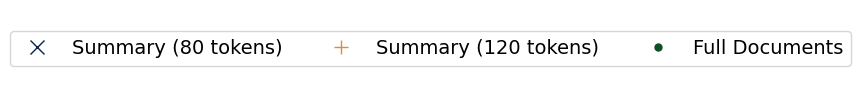

In [4]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
color_palette = {"summarisation_80tokens": "#09224f", "summarisation_120tokens": "#dd8a41", "fulldocs": "#0c5024"}
markers_palette = {"summarisation_80tokens": "x", "summarisation_120tokens": "+", "fulldocs": "."}
legend_labels = {
    "summarisation_80tokens": "Summary (80 tokens)",
    "summarisation_120tokens": "Summary (120 tokens)",
    "fulldocs": "Full Documents"
}
# Define dummy handles
plt_handles = []
for k in color_palette.keys():
    handle =  mlines.Line2D([], [], color=color_palette[k], marker=markers_palette[k], linestyle='None',
                             markersize=10, linewidth=3, label=legend_labels[k])
    plt_handles.append(handle)

# Create the legend only
fig = plt.figure(figsize=(8, 1.0))
ax = fig.add_subplot(111)
ax.axis("off")  # Hide axes
legend = ax.legend(handles=plt_handles,
                   loc="center",
                   ncol=3,
                   frameon=True, 
                   fontsize=14)

plt.savefig('figures/human_vs_summarise_scatter_legend.pdf',bbox_inches='tight', dpi=200)
plt.show()

dl-2019_gpt-4o_ndcg@10_scatter plot


/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


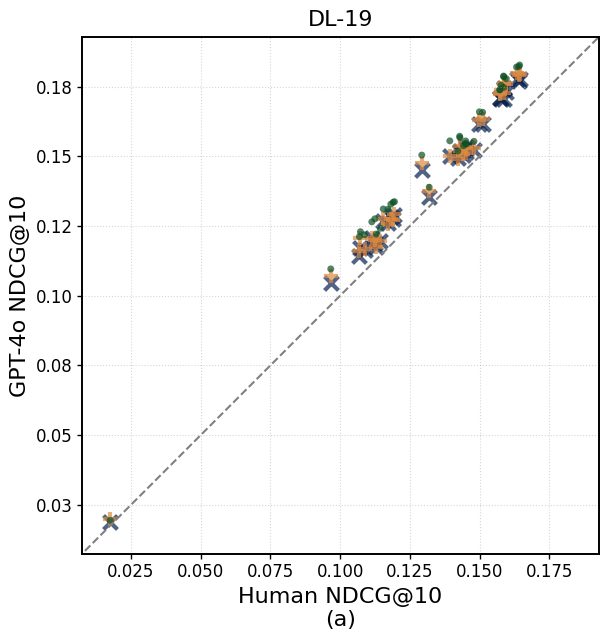

dl-2019_llama3.18b_ndcg@10_scatter plot


/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


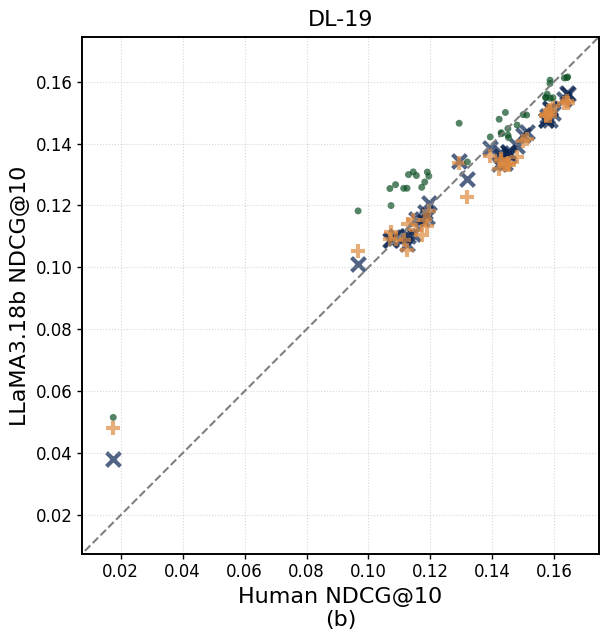

/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


dl-2019_gpt-4o_map_scatter plot


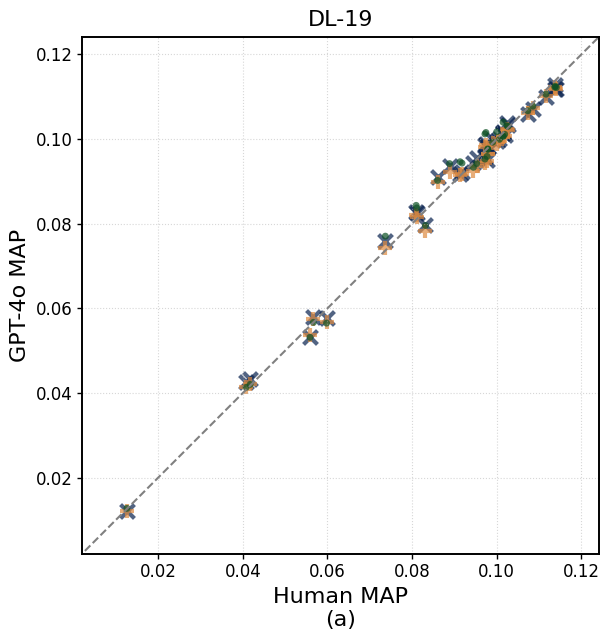

/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


dl-2019_llama3.18b_map_scatter plot


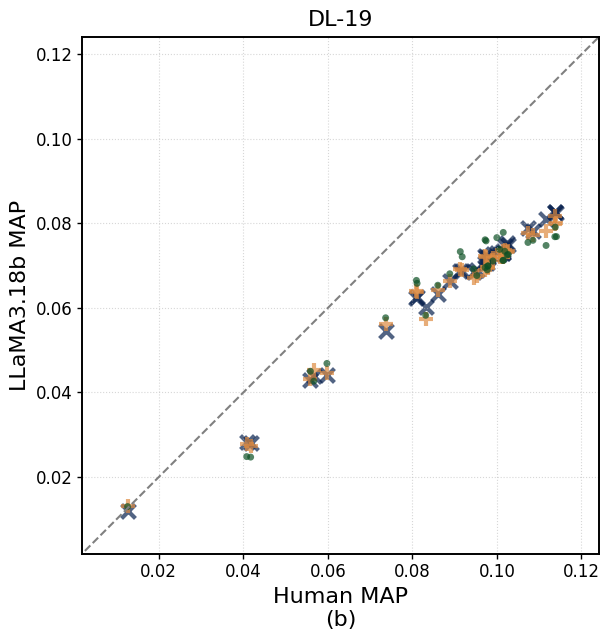

/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


dl-2020_gpt-4o_ndcg@10_scatter plot


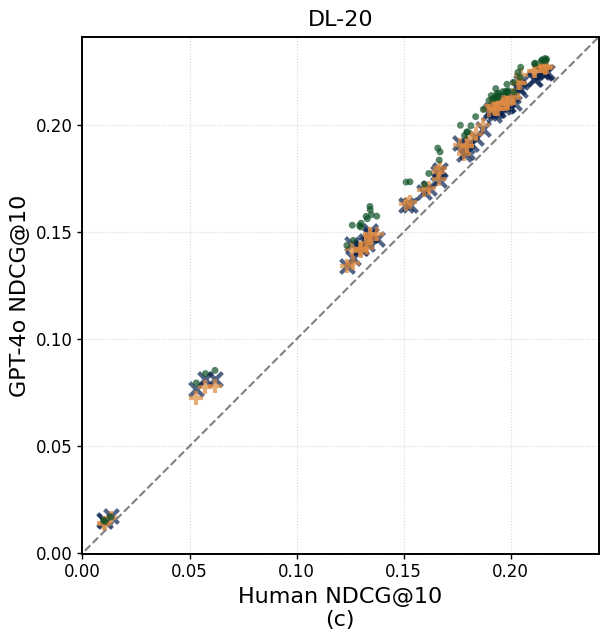

/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


dl-2020_llama3.18b_ndcg@10_scatter plot


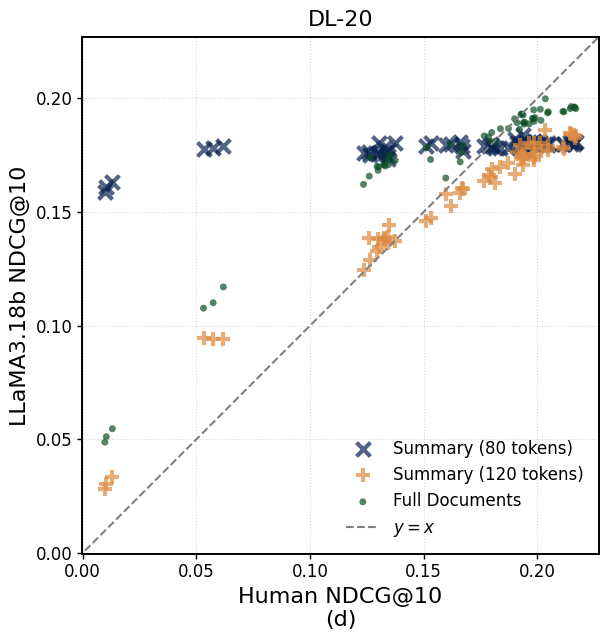

/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


dl-2020_gpt-4o_map_scatter plot


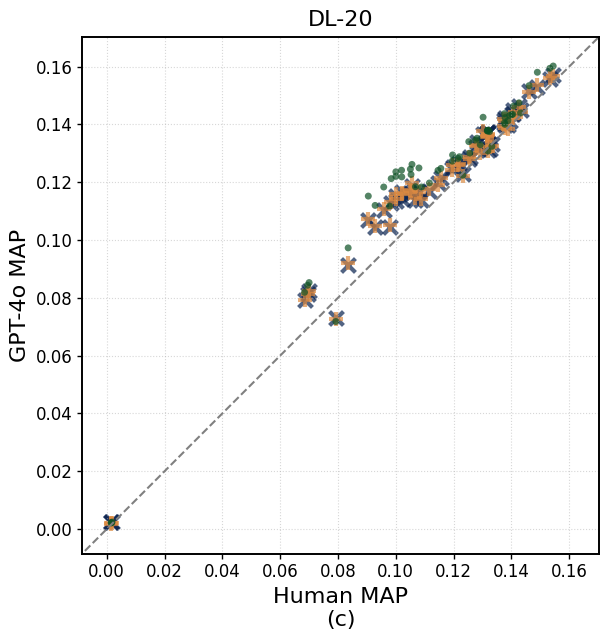

dl-2020_llama3.18b_map_scatter plot


/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_18884/989862985.py:92: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


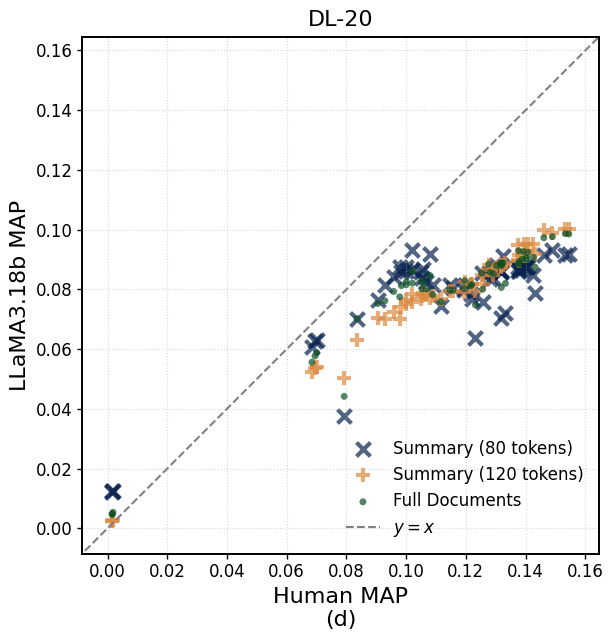

In [5]:
#Dl -019
plot_system_scatter_vs_human(
    "dl-2019",
    ["summarisation_80tokens", "summarisation_120tokens", "fulldocs"],
    "ndcg@10",
    ["gpt-4o", "llama3.18b"],
    human_scores,
    llm_scores,
    label_map,
    markers = markers_palette,
    colors = color_palette,
    figsize=(6.5, 6.5),
    sub_captions =["(a)","(b)"]
)
plot_system_scatter_vs_human(
    "dl-2019",
    ["summarisation_80tokens", "summarisation_120tokens", "fulldocs"],
    "map",
    ["gpt-4o", "llama3.18b"],
    human_scores,
    llm_scores,
    label_map,
    markers = markers_palette,
    colors = color_palette,
    figsize=(6.5, 6.5),
    sub_captions =["(a)","(b)"]

)
# DL-2020

plot_system_scatter_vs_human(
    "dl-2020",
    ["summarisation_80tokens", "summarisation_120tokens", "fulldocs"],
    "ndcg@10",
    ["gpt-4o", "llama3.18b"],
    human_scores,
    llm_scores,
    label_map,
    markers = markers_palette,
    colors = color_palette,
    figsize=(6.5, 6.5),
    sub_captions =["(c)","(d)"],
    legeend_on=True

)
plot_system_scatter_vs_human(
    "dl-2020",
    ["summarisation_80tokens", "summarisation_120tokens", "fulldocs"],
    "map",
    ["gpt-4o", "llama3.18b"],
    human_scores,
    llm_scores,
    label_map,
    markers = markers_palette,
    colors = color_palette,
    figsize=(6.5, 6.5),
    sub_captions =["(c)","(d)"],
    legeend_on=True

)

## Correlations

### Metric Calculation

In [2]:
import pickle
human_scores = pickle.load(open("pickled_objs/human_scores.pkl", "rb"))
llm_scores = pickle.load(open("pickled_objs/llm_scores.pkl", "rb"))
                              
dataset_name = 'dl-2019'
for key in llm_scores.keys():
    if key[:len(dataset_name)] != dataset_name:
        continue

    print(f"Correlation for: {key}")
    human_df = human_scores[dataset_name]['scores']
    llm_df = llm_scores[key]['scores']
    for metric in ['map', 'ndcg@10']:
        tau, r, rbo, n, aligned = compute_correlation_simple(llm_scores=llm_df, human_scores=human_df, metric=metric)
        llm_scores[key][f'correlation_{metric}'] = {
            "kendall_tau": float(tau),
            "spearman_r": float(r),
            "rbo": float(rbo),
            "n_common": int(n),
        }

dataset_name = 'dl-2020'
for key in llm_scores.keys():
    if key[:len(dataset_name)] != dataset_name:
        continue

    print(f"Correlation for: {key}")
    human_df = human_scores[dataset_name]['scores']
    llm_df = llm_scores[key]['scores']
    for metric in ['map', 'ndcg@10']:
        tau, r, rbo, n, aligned = compute_correlation_simple(llm_scores=llm_df, human_scores=human_df, metric=metric)
        llm_scores[key][f'correlation_{metric}'] = {
            "kendall_tau": float(tau),
            "spearman_r": float(r),
            "rbo": float(rbo),
            "n_common": int(n),
        }

os.makedirs("pickled_objs", exist_ok=True)
with open("pickled_objs/human_scores_sprman.pkl", "wb") as f:
    pickle.dump(human_scores, f)
with open("pickled_objs/llm_scores_sprman.pkl", "wb") as f:
    pickle.dump(llm_scores, f)

Correlation for: dl-2019gpt-4o_summarisation_80tokens
Correlation for: dl-2019llama3.18b_summarisation_80tokens
Correlation for: dl-2019gpt-4o_summarisation_120tokens
Correlation for: dl-2019llama3.18b_summarisation_120tokens
Correlation for: dl-2019gpt-4o_fulldocs
Correlation for: dl-2019llama3.18b_fulldocs
Correlation for: dl-2020gpt-4o_summarisation_80tokens
Correlation for: dl-2020llama3.18b_summarisation_80tokens
Correlation for: dl-2020gpt-4o_summarisation_120tokens
Correlation for: dl-2020llama3.18b_summarisation_120tokens
Correlation for: dl-2020gpt-4o_fulldocs
Correlation for: dl-2020llama3.18b_fulldocs


In [3]:
list(llm_scores.keys())

['dl-2019gpt-4o_summarisation_80tokens',
 'dl-2019llama3.18b_summarisation_80tokens',
 'dl-2019gpt-4o_summarisation_120tokens',
 'dl-2019llama3.18b_summarisation_120tokens',
 'dl-2019gpt-4o_fulldocs',
 'dl-2019llama3.18b_fulldocs',
 'dl-2020gpt-4o_summarisation_80tokens',
 'dl-2020llama3.18b_summarisation_80tokens',
 'dl-2020gpt-4o_summarisation_120tokens',
 'dl-2020llama3.18b_summarisation_120tokens',
 'dl-2020gpt-4o_fulldocs',
 'dl-2020llama3.18b_fulldocs']

In [4]:
from itertools import product
datasets = ['dl-2019', 'dl-2020']
models = ['gpt-4o', 'llama3.18b']
scenarios = ['summarisation_80tokens', 'summarisation_120tokens',   'fulldocs']
correlation_table = []
for dataset_name, model_name, scenario_name in product(datasets, models, scenarios):
    key = f"{dataset_name}{model_name}_{scenario_name}"
    if key not in llm_scores:
        print(f"[warn] Missing key: {key}")
        continue
    print(f"Correlations for: {key}")
    for metric in ['map', 'ndcg@10']:
        corr = llm_scores[key].get(f'correlation_{metric}', {})
        if corr:
            # print(f"  {metric}: {corr}")
            correlation_table.append({
                "dataset": dataset_name,
                "model": model_name,
                "scenario": scenario_name,
                "metric": metric} | corr)

correlation_table = pd.DataFrame(correlation_table)

Correlations for: dl-2019gpt-4o_summarisation_80tokens
Correlations for: dl-2019gpt-4o_summarisation_120tokens
Correlations for: dl-2019gpt-4o_fulldocs
Correlations for: dl-2019llama3.18b_summarisation_80tokens
Correlations for: dl-2019llama3.18b_summarisation_120tokens
Correlations for: dl-2019llama3.18b_fulldocs
Correlations for: dl-2020gpt-4o_summarisation_80tokens
Correlations for: dl-2020gpt-4o_summarisation_120tokens
Correlations for: dl-2020gpt-4o_fulldocs
Correlations for: dl-2020llama3.18b_summarisation_80tokens
Correlations for: dl-2020llama3.18b_summarisation_120tokens
Correlations for: dl-2020llama3.18b_fulldocs


In [5]:
pd.set_option('display.float_format', lambda x: f"{x:.3f}")
metric = 'ndcg@10'
model_name = 'llama3.18b'

display(correlation_table[correlation_table['metric']=='map'][correlation_table['model']=='gpt-4o'])
display(correlation_table[correlation_table['metric']=='map'][correlation_table['model']=='llama3.18b'])

display(correlation_table[correlation_table['metric']==metric][correlation_table['model']=='gpt-4o'])
display(correlation_table[correlation_table['metric']==metric][correlation_table['model']=='llama3.18b'])




/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_19446/2018976423.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(correlation_table[correlation_table['metric']=='map'][correlation_table['model']=='gpt-4o'])


,dataset,model,scenario,metric,kendall_tau,spearman_r,rbo,n_common
0,dl-2019,gpt-4o,summarisation_80tokens,map,0.934,0.990,0.850,37
2,dl-2019,gpt-4o,summarisation_120tokens,map,0.946,0.993,0.814,37
4,dl-2019,gpt-4o,fulldocs,map,0.886,0.968,0.771,37
12,dl-2020,gpt-4o,summarisation_80tokens,map,0.924,0.987,0.950,59
14,dl-2020,gpt-4o,summarisation_120tokens,map,0.915,0.986,0.946,59
16,dl-2020,gpt-4o,fulldocs,map,0.874,0.969,0.927,59


/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_19446/2018976423.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(correlation_table[correlation_table['metric']=='map'][correlation_table['model']=='llama3.18b'])


,dataset,model,scenario,metric,kendall_tau,spearman_r,rbo,n_common
6,dl-2019,llama3.18b,summarisation_80tokens,map,0.940,0.992,0.801,37
8,dl-2019,llama3.18b,summarisation_120tokens,map,0.889,0.977,0.812,37
10,dl-2019,llama3.18b,fulldocs,map,0.742,0.874,0.589,37
18,dl-2020,llama3.18b,summarisation_80tokens,map,0.427,0.563,0.464,59
20,dl-2020,llama3.18b,summarisation_120tokens,map,0.917,0.988,0.897,59
22,dl-2020,llama3.18b,fulldocs,map,0.738,0.885,0.775,59


/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_19446/2018976423.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(correlation_table[correlation_table['metric']==metric][correlation_table['model']=='gpt-4o'])


,dataset,model,scenario,metric,kendall_tau,spearman_r,rbo,n_common
1,dl-2019,gpt-4o,summarisation_80tokens,ndcg@10,0.922,0.989,0.845,37
3,dl-2019,gpt-4o,summarisation_120tokens,ndcg@10,0.910,0.984,0.771,37
5,dl-2019,gpt-4o,fulldocs,ndcg@10,0.892,0.976,0.887,37
13,dl-2020,gpt-4o,summarisation_80tokens,ndcg@10,0.937,0.992,0.698,59
15,dl-2020,gpt-4o,summarisation_120tokens,ndcg@10,0.929,0.989,0.694,59
17,dl-2020,gpt-4o,fulldocs,ndcg@10,0.938,0.991,0.792,59


/var/folders/y4/3dvrf2sn66jdhgh63m7nhw71rhdqg1/T/ipykernel_19446/2018976423.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(correlation_table[correlation_table['metric']==metric][correlation_table['model']=='llama3.18b'])


,dataset,model,scenario,metric,kendall_tau,spearman_r,rbo,n_common
7,dl-2019,llama3.18b,summarisation_80tokens,ndcg@10,0.910,0.982,0.801,37
9,dl-2019,llama3.18b,summarisation_120tokens,ndcg@10,0.844,0.961,0.769,37
11,dl-2019,llama3.18b,fulldocs,ndcg@10,0.829,0.952,0.852,37
19,dl-2020,llama3.18b,summarisation_80tokens,ndcg@10,0.480,0.679,0.296,59
21,dl-2020,llama3.18b,summarisation_120tokens,ndcg@10,0.856,0.964,0.537,59
23,dl-2020,llama3.18b,fulldocs,ndcg@10,0.850,0.964,0.610,59


## Bootstrap confidence intervals for correlations

In [ ]:
# =========================
# Windows-friendly trectools solution
# =========================
from __future__ import annotations
import os, glob
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import kendalltau

pd.set_option('display.float_format', lambda x: f"{x:.5f}")

# ---- grids ----
datasets  = ['dl-2019', 'dl-2020']
scenarios = ['summarisation_80tokens', 'summarisation_120tokens', 'fulldocs']
models    = ['gpt-4o', 'llama3.18b']

K        = 10      # NDCG cutoff
N_BOOT   = 2000
ALPHA    = 0.05
AGG      = "mean"
SEED     = 17

# =========================
# Per-topic NDCG via trectools
# =========================
def _to_topic_dict_from_df(df, k: int):
    import pandas as _pd
    if df is None:
        return None
    # Normalize to DataFrame
    if isinstance(df, _pd.Series):
        df = df.to_frame(name=f"ndcg_cut_{k}").reset_index()
    elif not isinstance(df, _pd.DataFrame):
        try:
            df = _pd.DataFrame(df)
        except Exception:
            return None

    # find topic column
    topic_col = None
    for tcol in ("topic", "qid", "query", "q", "QueryID"):
        if tcol in df.columns:
            topic_col = tcol; break
    if topic_col is None and getattr(df.index, "name", None) in ("topic","qid","query","q","QueryID"):
        topic_col = df.index.name
        df = df.reset_index()
    if topic_col is None:
        # try to guess: first column if it looks categorical
        topic_col = df.columns[0]

    # find an ndcg@k column
    cand = [c for c in df.columns if str(k) in str(c).lower() and "ndcg" in str(c).lower()]
    if not cand:
        cand = [c for c in df.columns if str(c).lower() in (f"ndcg_cut_{k}", f"ndcg@{k}", f"ndcg_{k}")]
    if not cand:
        return None
    col = cand[0]

    out = {}
    for _, r in df[[topic_col, col]].dropna().iterrows():
        out[str(r[topic_col])] = float(r[col])
    return out

def per_topic_ndcg_trectools(qrels_path: str | Path, run_path: str | Path, k: int = 10) -> dict[str, float]:
    """
    Return {topic_id: ndcg@k} for a single run using trectools.
    Accepts dict, DataFrame, or Series returns (varies by trectools version).
    """
    from trectools import TrecQrel, TrecRun, TrecEval
    qrel = TrecQrel(str(qrels_path))
    run  = TrecRun(str(run_path))
    te   = TrecEval(run, qrel)

    # 1) get_ndcg(depth=k, per_query=True) — named arg
    try:
        val = te.get_ndcg(depth=k, per_query=True)
        if isinstance(val, dict):
            return {str(q): float(v) for q, v in val.items()}
        out = _to_topic_dict_from_df(val, k)
        if out: return out
    except Exception:
        pass

    # 2) get_ndcg(k, per_query=True) — positional depth
    try:
        val = te.get_ndcg(k, per_query=True)
        if isinstance(val, dict):
            return {str(q): float(v) for q, v in val.items()}
        out = _to_topic_dict_from_df(val, k)
        if out: return out
    except Exception:
        pass

    # 3) get_ndcg(depth=k) — some builds return a dict per query here
    try:
        val = te.get_ndcg(depth=k)
        if isinstance(val, dict):
            return {str(q): float(v) for q, v in val.items()}
        out = _to_topic_dict_from_df(val, k)
        if out: return out
    except Exception:
        pass

    # 4) metric-specific method get_ndcg_cut_{k} (sometimes returns dict/DataFrame)
    try:
        meth = getattr(te, f"get_ndcg_cut_{k}", None)
        if callable(meth):
            val = meth()
            if isinstance(val, dict):
                return {str(q): float(v) for q, v in val.items()}
            out = _to_topic_dict_from_df(val, k)
            if out: return out
    except Exception:
        pass

    # 5) per-query table (common on some Windows installs)
    for attr in ("get_res_per_query", "perquery", "per_query", "evaluate_queries"):
        obj = getattr(te, attr, None)
        try:
            pq = obj() if callable(obj) else obj
        except Exception:
            pq = None
        out = _to_topic_dict_from_df(pq, k)
        if out: return out

    raise RuntimeError(
        f"Could not get per-topic NDCG@{k} via trectools for run: {run_path}. "
        "Try updating trectools (>= 0.0.50) or check the qrels/run topic IDs."
    )


def build_system_topic_matrix_from_runs_trectools(qrels_path: str | Path, runs_dir: str | Path, k: int = 10) -> pd.DataFrame:
    """
    For each run file in runs_dir, compute per-topic ndcg@k and return a system×topic matrix.
    """
    run_paths = sorted(glob.glob(os.path.join(str(runs_dir), "*")))
    if not run_paths:
        raise FileNotFoundError(f"No run files found in: {runs_dir}")

    rows = []
    for rp in run_paths:
        sys_name = os.path.basename(rp)
        try:
            ndcg_dict = per_topic_ndcg_trectools(qrels_path, rp, k=k)
            for qid, val in ndcg_dict.items():
                rows.append({"system": sys_name, "topic": str(qid), f"ndcg@{k}": float(val)})
        except Exception as e:
            print(f"[warn] Skipping {sys_name}: {e}")

    if not rows:
        raise RuntimeError("No per-topic rows; check qrels/runs compatibility.")
    tidy = pd.DataFrame(rows).sort_values(["system","topic"]).reset_index(drop=True)
    mat  = tidy.pivot(index="system", columns="topic", values=f"ndcg@{k}") \
               .sort_index(axis=0).sort_index(axis=1)
    return mat

# =========================
# Alignment + topic bootstrap
# =========================
def intersect_systems_topics(*mats: pd.DataFrame) -> tuple[pd.DataFrame, ...]:
    sys_common = set(mats[0].index)
    top_common = set(mats[0].columns)
    for M in mats[1:]:
        sys_common &= set(M.index)
        top_common &= set(M.columns)
    if not sys_common or not top_common:
        raise ValueError("No common systems/topics across modalities after intersection.")
    sys_sorted = sorted(sys_common)
    top_sorted = sorted(top_common)
    return tuple(M.loc[sys_sorted, top_sorted] for M in mats)

def bootstrap_kendall_over_topics(H: pd.DataFrame, S: pd.DataFrame, F: pd.DataFrame,
                                  n_boot: int = 2000, alpha: float = 0.05,
                                  agg: str = "mean", seed: int = 17) -> dict[str, dict]:
    rng = np.random.default_rng(seed)
    n_topics = H.shape[1]
    taus_HF = np.empty(n_boot)
    taus_HS = np.empty(n_boot)
    taus_FS = np.empty(n_boot)

    def _agg(M: pd.DataFrame, idx: np.ndarray) -> np.ndarray:
        sampled = M.iloc[:, idx]
        if agg == "mean":
            return sampled.mean(axis=1).to_numpy(dtype=float)
        elif agg == "median":
            return sampled.median(axis=1).to_numpy(dtype=float)
        else:
            raise ValueError(f"Unknown agg: {agg}")

    for b in range(n_boot):
        idx = rng.integers(0, n_topics, size=n_topics)  # bootstrap topics
        h_sys = _agg(H, idx)
        s_sys = _agg(S, idx)
        f_sys = _agg(F, idx)

        taus_HF[b] = kendalltau(h_sys, f_sys, nan_policy="omit")[0]
        taus_HS[b] = kendalltau(h_sys, s_sys, nan_policy="omit")[0]
        taus_FS[b] = kendalltau(f_sys, s_sys, nan_policy="omit")[0]

    def _summ(arr):
        return dict(
            tau_mean=float(np.nanmean(arr)),
            tau_lo=float(np.nanpercentile(arr, 100*(alpha/2))),
            tau_hi=float(np.nanpercentile(arr, 100*(1 - alpha/2))),
            taus=arr,
        )

    return {
        "Full vs Human":    _summ(taus_HF),
        "Summary vs Human": _summ(taus_HS),
        "Summary vs Full":  _summ(taus_FS),
    }

_matrix_cache: dict[tuple[str, str, int], pd.DataFrame] = {}

def get_matrix_cached(qrels_path: str, runs_dir: str, k: int) -> pd.DataFrame:
    key = (os.path.abspath(qrels_path), os.path.abspath(runs_dir), k)
    if key not in _matrix_cache:
        _matrix_cache[key] = build_system_topic_matrix_from_runs_trectools(qrels_path, runs_dir, k=k)
    return _matrix_cache[key]

rows = []
for dataset_name in datasets:
    runs_dir = f"../data/runs/trec-{dataset_name}"

    # human qrels (once per dataset)
    human_qrels = f"../data/msmarco-passage-trec-{dataset_name}-judged/qrels/trec.qrels.txt"
    H = get_matrix_cached(human_qrels, runs_dir, K)

    for model_name in models:
        # full-docs qrels for model/dataset
        qrels_full = f"../data/msmarco-passage-trec-{dataset_name}-judged/qrels/{model_name}_umbrella_zeroshot_qrels_fulldocs.txt"
        F = get_matrix_cached(qrels_full, runs_dir, K)

        # summary scenarios (skip fulldocs here)
        for scenario_name in [s for s in scenarios if s != "fulldocs"]:
            print(f"Processing: {dataset_name} | {model_name} | {scenario_name}")

            qrels_summary = f"../data/msmarco-passage-trec-{dataset_name}-judged/qrels/{model_name}_umbrella_zeroshot_qrels_{scenario_name}.txt"
            S = get_matrix_cached(qrels_summary, runs_dir, K)

            # align and bootstrap
            H_, S_, F_ = intersect_systems_topics(H, S, F)
            comps = bootstrap_kendall_over_topics(H_, S_, F_, n_boot=N_BOOT, alpha=ALPHA, agg=AGG, seed=SEED)

            flat = {f"{k}:{m}": v for k, d in comps.items() for m, v in d.items() if m != "taus"}
            rows.append({
                "dataset": dataset_name,
                "model": model_name,
                "scenario": scenario_name,
                "n_systems": H_.shape[0],
                "n_topics": H_.shape[1],
                **flat
            })

df_tau_ci = pd.DataFrame(rows)
display(df_tau_ci)

# Caption is now accurate:
# "Kendall’s τ for NDCG@10-based system rankings with 95% confidence intervals
#  from 2000 bootstrap resamples over topics."


Processing: dl-2019 | gpt-4o | summarisation_80tokens
Processing: dl-2019 | gpt-4o | summarisation_120tokens
Processing: dl-2019 | llama3.18b | summarisation_80tokens
Processing: dl-2019 | llama3.18b | summarisation_120tokens
Processing: dl-2020 | gpt-4o | summarisation_80tokens
Processing: dl-2020 | gpt-4o | summarisation_120tokens
Processing: dl-2020 | llama3.18b | summarisation_80tokens
Processing: dl-2020 | llama3.18b | summarisation_120tokens


,dataset,model,scenario,n_systems,n_topics,Full vs Human:tau_mean,Full vs Human:tau_lo,Full vs Human:tau_hi,Summary vs Human:tau_mean,Summary vs Human:tau_lo,Summary vs Human:tau_hi,Summary vs Full:tau_mean,Summary vs Full:tau_lo,Summary vs Full:tau_hi
0,dl-2019,gpt-4o,summarisation_80tokens,37,43,0.87674,0.79580,0.93401,0.88574,0.81081,0.94294,0.93943,0.89189,0.97523
1,dl-2019,gpt-4o,summarisation_120tokens,37,43,0.87674,0.79580,0.93401,0.86195,0.78378,0.92500,0.92014,0.86486,0.96096
2,dl-2019,llama3.18b,summarisation_80tokens,37,43,0.77598,0.66366,0.86486,0.83499,0.73681,0.90991,0.79649,0.71171,0.87002
3,dl-2019,llama3.18b,summarisation_120tokens,37,43,0.77598,0.66366,0.86486,0.79568,0.69970,0.86792,0.80824,0.71971,0.88204
4,dl-2020,gpt-4o,summarisation_80tokens,59,54,0.88786,0.82934,0.92753,0.88879,0.83168,0.93103,0.94300,0.91347,0.96727
5,dl-2020,gpt-4o,summarisation_120tokens,59,54,0.88786,0.82934,0.92753,0.88635,0.82700,0.92989,0.94201,0.91233,0.96610
6,dl-2020,llama3.18b,summarisation_80tokens,59,54,0.76969,0.64813,0.84924,0.81960,0.72648,0.88428,0.75598,0.63998,0.83168
7,dl-2020,llama3.18b,summarisation_120tokens,59,54,0.76969,0.64813,0.84924,0.81826,0.74047,0.87960,0.76022,0.62829,0.84570


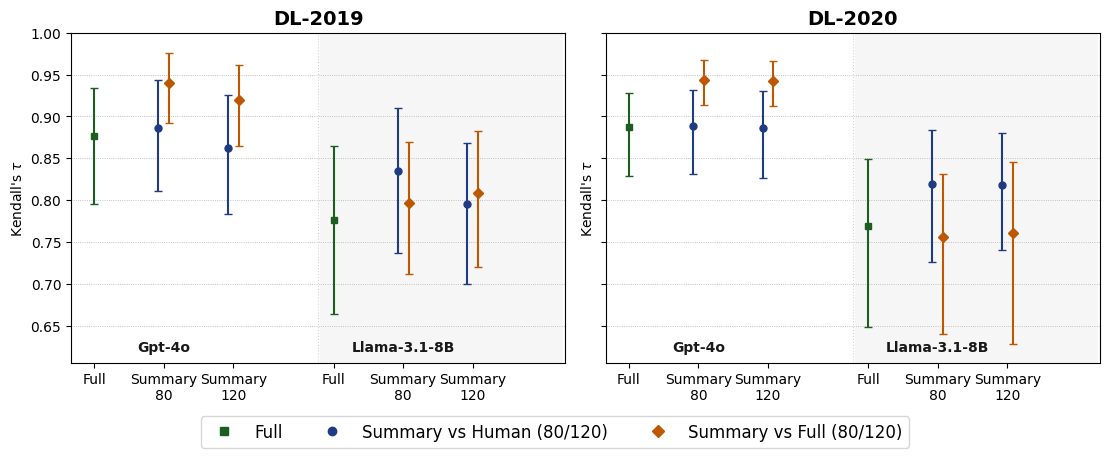

In [7]:
df_tau_ci.to_csv("summarisation_outputs/tau_ci_bootstrap_per_topic.csv", index=False)
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# vector-friendly fonts
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42

# --------------------------------------------------------------------
# CONFIG

COL = {
    "HF":  "#1b5e20",   # green   (Full vs Human)
    "HS":  "#1f3b82",   # blue    (Summary vs Human)
    "FS":  "#bf5700",   # orange  (Summary vs Full)
}
MARK = {"HF": "s", "HS": "o", "FS": "D"}  # square, circle, diamond

DATASETS = ("dl-2019", "dl-2020")
MODELS   = ("gpt-4o", "llama3.18b")
SCEN_80  = "summarisation_80tokens"
SCEN_120 = "summarisation_120tokens"

# --------------------------------------------------------------------
# HELPERS

def _err(ax, x, est, lo, hi, color, marker):
    yerr = np.array([[est - lo], [hi - est]])
    ax.errorbar(
        x, est, yerr=yerr,
        fmt=marker, ms=5, color=color,
        capsize=3, elinewidth=1.5, lw=0.8
    )

def _get_row(df, dataset, model, scenario=None):
    sub = df[(df["dataset"]==dataset) & (df["model"]==model)]
    if scenario is not None:
        sub = sub[sub["scenario"]==scenario]
    return sub.iloc[0]

# --------------------------------------------------------------------
# MAIN PLOT

def plot_tau_ci_two_panels_from_numeric(
    df_tau_ci,
    datasets=DATASETS,
    models=MODELS,
    outpath="figures/tau_ci_panels_bootstrap_querybased.pdf"
):
    # y-range from all means
    all_means = []
    for col in [
        "Full vs Human:tau_mean",
        "Summary vs Human:tau_mean",
        "Summary vs Full:tau_mean",
    ]:
        all_means.extend(df_tau_ci[col].tolist())
    y_min = max(0.0, min(all_means) - 0.15)
    y_max = min(1.0, max(all_means) + 0.12)

    fig, axes = plt.subplots(1, 2, figsize=(11.2, 4.6), sharey=True)

    # layout params: 2 model sections per panel; each section has 3 x-centers
    gap  = 0.8     # gap between model sections
    step = 1.8     # spacing between Full / Summary80 / Summary120 within a section
    off  = 0.14    # small offset between HS (blue) and FS (orange) at a scenario center

    for ax, ds in zip(axes, datasets):
        xticks, xticklabels = [], []
        xpos = 0.0

        for i, m in enumerate(models):
            # --- Full vs Human (use once per model) ---
            r_any = _get_row(df_tau_ci, ds, m)  # any scenario row
            hf_m  = r_any["Full vs Human:tau_mean"]
            hf_lo = r_any["Full vs Human:tau_lo"]
            hf_hi = r_any["Full vs Human:tau_hi"]
            _err(ax, xpos + 0*step, hf_m, hf_lo, hf_hi, COL["HF"], MARK["HF"])

            # --- Summary 80: Human and Full comparisons, offsetted ---
            r80   = _get_row(df_tau_ci, ds, m, SCEN_80)
            hs80m, hs80lo, hs80hi = r80["Summary vs Human:tau_mean"], r80["Summary vs Human:tau_lo"], r80["Summary vs Human:tau_hi"]
            fs80m, fs80lo, fs80hi = r80["Summary vs Full:tau_mean"],   r80["Summary vs Full:tau_lo"],   r80["Summary vs Full:tau_hi"]
            xc80 = xpos + 1*step
            _err(ax, xc80 - off, hs80m, hs80lo, hs80hi, COL["HS"], MARK["HS"])
            _err(ax, xc80 + off, fs80m, fs80lo, fs80hi, COL["FS"], MARK["FS"])

            # --- Summary 120: Human and Full comparisons, offsetted ---
            r120   = _get_row(df_tau_ci, ds, m, SCEN_120)
            hs120m, hs120lo, hs120hi = r120["Summary vs Human:tau_mean"], r120["Summary vs Human:tau_lo"], r120["Summary vs Human:tau_hi"]
            fs120m, fs120lo, fs120hi = r120["Summary vs Full:tau_mean"],   r120["Summary vs Full:tau_lo"],   r120["Summary vs Full:tau_hi"]
            xc120 = xpos + 2*step
            _err(ax, xc120 - off, hs120m, hs120lo, hs120hi, COL["HS"], MARK["HS"])
            _err(ax, xc120 + off, fs120m, fs120lo, fs120hi, COL["FS"], MARK["FS"])

            # tick centers for this model
            xticks      += [xpos + 0*step, xpos + 1*step, xpos + 2*step]
            xticklabels += ["Full", "Summary\n80", "Summary\n120"]

            # vertical separator between models
            if i == 0:
                ax.axvline(xpos + 3*step + (gap/2), color="lightgray", lw=0.8, linestyle=":")

            xpos += 3*step + gap

        # --- shade the right section (LLaMA3.18b) ---
        llama_left  = (3*step + gap) - 0.35        # left edge of second section
        llama_right = (3*step + gap) + 3*step + 0.55  # right edge of second section
        ax.axvspan(llama_left, llama_right, facecolor="lightgrey", alpha=0.2, zorder=0)
        # cosmetics
        ax.set_ylim(y_min, y_max)
        ax.set_xlim(-0.6, xpos - gap + 0.6)
        ax.set_ylabel("Kendall's $\\tau$")
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, fontsize=10)
        ax.set_title(ds.upper(),fontweight="bold", fontsize=14)
        ax.grid(True, axis="y", linestyle=":", linewidth=0.6)

        # model labels under each section (optional)
        sec_centers = [0.0 + step, (3*step + gap) + step]
        for c, mdl in zip(sec_centers, ['Gpt-4o', 'Llama-3.1-8B']):
            ax.text(c, y_min + 0.01, mdl, ha="center", va="bottom", fontsize=10, alpha=0.9, fontweight="bold")

    # legend (shared)
    handles = [
        plt.Line2D([0],[0], color=COL["HF"], marker=MARK["HF"], lw=0, label="Full"),
        plt.Line2D([0],[0], color=COL["HS"], marker=MARK["HS"], lw=0, label="Summary vs Human (80/120)"),
        plt.Line2D([0],[0], color=COL["FS"], marker=MARK["FS"], lw=0, label="Summary vs Full (80/120)"),
    ]
    fig.legend(handles=handles, loc="lower center", ncol=3, frameon=True, fontsize=12)

    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.savefig(outpath, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# --- usage ---
plot_tau_ci_two_panels_from_numeric(df_tau_ci)
